<a href="https://colab.research.google.com/github/mkorob/DementiaDataSynthEval/blob/main/SyntheticDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import re

In [ ]:
orig_data = pd.read_csv("/content/final_data_texts_w_features (2).csv")

In [ ]:
biased_predictions = pd.read_csv("/content/generated_biased_predictions_unshuffled.csv")
unbiased_predictions = pd.read_csv("/content/generated_unbiased_predictions_unshuffled.csv")

In [ ]:
biased_predictions_shuffled = pd.read_csv("/content/generated_biased_predictions_shuffled.csv")

In [ ]:
unbiased_predictions_shuffled = pd.read_csv("/content/generated_unbiased_predictions_shuffled (2).csv")

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
import xlrd
book = xlrd.open_workbook("/content/SUBTLEXusfrequencyabove1.xls")

In [ ]:
sh = book.sheet_by_index(0)

In [ ]:
freq_count = pd.DataFrame(sh)
freq_count.columns = freq_count.loc[0, :]

## Generate Data Features

In [ ]:
def first_snippet_select(filtered_sentences):
    processed_text = ""
    word_count = 0
    #remove first sentence
    for sentence in filtered_sentences:
        words = nltk.word_tokenize(sentence)
        if word_count + len(words) <= 200:
            processed_text += sentence + " "
            word_count += len(words)
        else:
            remaining_words = 200 - word_count
            processed_text += " ".join(words[:remaining_words])
            break

    return processed_text

In [ ]:
def extract_value(cell):
  return cell.value

In [ ]:
freq_count['Word'] = freq_count[freq_count.columns[0]].apply(extract_value).str.lower()
freq_count['Lg10CD'] = freq_count[freq_count.columns[8]].apply(extract_value)

In [ ]:
freq_count = freq_count.loc[1:, :]

In [ ]:
freq_count.head()

,text:'Word',text:'FREQcount',text:'CDcount',text:'FREQlow',text:'Cdlow',text:'SUBTLWF',text:'Lg10WF',text:'SUBTLCD',text:'Lg10CD',Word,Lg10CD
1,text:'the',number:1501908.0,number:8388.0,number:1339811.0,number:8388.0,number:29449.176470588234,number:6.176643619755298,number:100.0,number:3.9237101943965627,the,3.92371
2,text:'to',number:1156570.0,number:8383.0,number:1138435.0,number:8380.0,number:22677.843137254902,number:6.063172298552158,number:99.94039103481164,number:3.9234512696396515,to,3.923451
3,text:'a',number:1041179.0,number:8382.0,number:976941.0,number:8380.0,number:20415.274509803923,number:6.017525817165722,number:99.92846924177397,number:3.9233994661587164,a,3.923399
4,text:'you',number:2134713.0,number:8381.0,number:1595028.0,number:8376.0,number:41857.117647058825,number:6.329339698310973,number:99.9165474487363,number:3.9233476564978256,you,3.923348
5,text:'and',number:682780.0,number:8379.0,number:515365.0,number:8374.0,number:13387.843137254902,number:5.834281427337299,number:99.89270386266095,number:3.9232440186302764,and,3.923244


In [ ]:
def get_SUBTL_score(word):
  log_count = freq_count['Lg10CD'][freq_count['Word'] == word]
  if len(log_count) > 0:
    return log_count.values[0]

In [ ]:
import numpy as np
from collections import Counter
import string

word_count_snippet = 200

def calculate_features(text):

  words = nltk.word_tokenize(text)
  sentences = nltk.sent_tokenize(text)

  # Remove punctuation from words
  sentence_words = [word for word in words if word not in string.punctuation]

  if len(words) >= 200:
    # Remove sentences with less than three words
      filtered_sentences = [sentence for sentence in sentences if len(tokenizer.tokenize(sentence)) >= 4]
      filtered_text = first_snippet_select(filtered_sentences)
      filtered_words = nltk.word_tokenize(filtered_text)

      # Tag parts of speech
      pos_tags = nltk.pos_tag(filtered_words)


      #correlation - 0.42
      def determiner_noun_phrase_ratio(pos_tags):
          determiners = sum(1 for word, pos in pos_tags if pos == 'DT')
          noun_phrases = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS'])
          return determiners / noun_phrases if noun_phrases > 0 else 0

      #just for baseline - not a real feature because capped
      def word_count(words):
          return len(words)

      #PAST tense verbs and vp_np_ratio
      def vp_np_ratio(pos_tags):
          verb_phrases = sum(1 for word, pos in pos_tags if pos in ['VBD', 'VBN'])
          noun_phrases = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS'])
          return verb_phrases, verb_phrases / noun_phrases if noun_phrases > 0 else 0

      #correlation - -0.38
      def coordinate_phrases_ratio(pos_tags):
          coordinate_conjunctions = sum(1 for word, pos in pos_tags if pos == 'CC')
          phrases = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
          return coordinate_conjunctions / phrases if phrases > 0 else 0

      #correlation - 0.46
      def subordinate_ratio(pos_tags):
          subordinate_conjunctions = sum(1 for word, pos in pos_tags if pos in ['IN', 'RP'])
          coordinate_conjunctions = sum(1 for word, pos in pos_tags if pos == 'CC')
          return subordinate_conjunctions / coordinate_conjunctions if coordinate_conjunctions > 0 else 0

      #correlation - 0.74
      def avg_word_length(words):
          return np.mean([len(word) for word in words])

      #correlation - 0.37
      def proportion_subjects(pos_tags):
          subjects = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS'])
          return subjects / len(words) if len(words) > 0 else 0

      # Calculate the features
      verbs, vp_np_ratio_val = vp_np_ratio(pos_tags)

      features = {
          'filtered_words': " ".join(filtered_words),
          'determiner_noun_phrase_ratio': determiner_noun_phrase_ratio(pos_tags),
          'past_tense_verbs': verbs,
          'word_count_snip': word_count(filtered_words),
          'vp_np_ratio': vp_np_ratio_val,
          'coordinate_phrases_ratio': coordinate_phrases_ratio(pos_tags),
          'subordinate_ratio': subordinate_ratio(pos_tags),
          'avg_word_length': avg_word_length(filtered_words),
          'proportion_subjects': proportion_subjects(pos_tags),
          'SUBTL_score': [get_SUBTL_score(word.lower()) for word in filtered_words]
      }

      return features

  return

In [ ]:
def clean_transcript(text):

    # Remove newlines and replace with spaces
    text = text.replace('\n', ' ')

    # Remove timestamps in the format (hh:mm) or hh:mm
    text = re.sub(r'\(\d{1,2}:\d{2}\)', '', text)  # Removes (hh:mm)
    text = re.sub(r'\b\d{1,2}:\d{2}\b', '', text)  # Removes hh:mm

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    #clean transcript cues
    # Remove text inside square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove newlines
    text = text.replace('\n', ' ')
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
unbiased_predictions

,Unnamed: 0,ID,prompt,prediction
0,0,dem1,Your task is to write a blog entry in the writ...,"Good morning, everyone! It's Agnes from Coatbr..."
1,1,dem1,Your task is to write a blog entry in the writ...,"Good morning everybody, it's Agnes from Coatbr..."
2,2,dem1,Your task is to write a blog entry in the writ...,"Good morning everybody, it's Agnes from Coatbr..."
3,3,dem1,Your task is to write a blog entry in the writ...,"Good morning everybody, it's Agnes from Coatbr..."
4,4,dem1,Your task is to write a blog entry in the writ...,"Good morning everybody, it's Agnes from Coatbr..."
...,...,...,...,...
195,195,con6,Your task is to write a blog entry in the writ...,"Welcome to The Overwhelmed Brain, where we div..."
196,196,con6,Your task is to write a blog entry in the writ...,"Welcome to The Overwhelmed Brain, where we div..."
197,197,con6,Your task is to write a blog entry in the writ...,"Welcome to The Overwhelmed Brain, where we div..."
198,198,con6,Your task is to write a blog entry in the writ...,"Welcome to The Overwhelmed Brain, where we div..."


In [ ]:
# Apply the function to create new columns in the DataFrame
biased_features = biased_predictions['prediction'].apply(clean_transcript).apply(lambda x: pd.Series(calculate_features(x)))

# Concatenate the original DataFrame with the new features DataFrame
df_biased = pd.concat([biased_predictions[['ID', 'prediction']], biased_features], axis=1)

In [ ]:
# Apply the function to create new columns in the DataFrame
biased_features_shuffled = biased_predictions_shuffled['prediction'].apply(clean_transcript).apply(lambda x: pd.Series(calculate_features(x)))

# Concatenate the original DataFrame with the new features DataFrame
df_biased_shuffled= pd.concat([biased_predictions_shuffled[['ID', 'prediction']], biased_features_shuffled], axis=1)

In [ ]:
features = ['determiner_noun_phrase_ratio', 'past_tense_verbs', 'vp_np_ratio', 'coordinate_phrases_ratio', 'subordinate_ratio', 'avg_word_length','proportion_subjects', 'SUBTL_score_mean']

In [ ]:
df_biased = df_biased.dropna(subset = features[0]).reset_index(drop = True)
df_biased_shuffled = df_biased_shuffled.dropna(subset = features[0]).reset_index(drop = True)

In [ ]:
df_biased['SUBTL_score_mean'] = df_biased['SUBTL_score'].apply(lambda x: np.mean([y for y in x if y is not None]))
df_biased_shuffled['SUBTL_score_mean'] = df_biased_shuffled['SUBTL_score'].apply(lambda x: np.mean([y for y in x if y is not None]))

In [ ]:
# Apply the function to create new columns in the DataFrame
unbiased_features = unbiased_predictions['prediction'].apply(clean_transcript).apply(lambda x: pd.Series(calculate_features(x)))

# Concatenate the original DataFrame with the new features DataFrame
df_unbiased = pd.concat([unbiased_predictions[['ID', 'prediction']], unbiased_features], axis=1)

In [ ]:
# Apply the function to create new columns in the DataFrame
unbiased_features_shuffled = unbiased_predictions_shuffled['prediction'].apply(clean_transcript).apply(lambda x: pd.Series(calculate_features(x)))

# Concatenate the original DataFrame with the new features DataFrame
df_unbiased_shuffled = pd.concat([unbiased_predictions_shuffled[['ID', 'prediction']], unbiased_features_shuffled], axis=1)

In [ ]:
df_unbiased = df_unbiased.dropna(subset = features[0]).reset_index(drop = True)
df_unbiased_shuffled = df_unbiased_shuffled.dropna(subset = features[0]).reset_index(drop = True)

In [ ]:
df_unbiased['SUBTL_score_mean'] = df_unbiased['SUBTL_score'].apply(lambda x: np.mean([y for y in x if y is not None]))
df_unbiased_shuffled['SUBTL_score_mean'] = df_unbiased_shuffled['SUBTL_score'].apply(lambda x: np.mean([y for y in x if y is not None]))

In [ ]:
df_biased['group'] = df_biased['ID'].str[:3]
df_unbiased['group'] = df_biased['ID'].str[:3]
df_biased_shuffled['group'] = df_biased_shuffled['ID'].str[:3]
df_unbiased_shuffled['group'] = df_biased_shuffled['ID'].str[:3]

## Hypotheses 1 and 2 - Original and Unbiased Data

### Hypothesis 1- Comparing Means

In [ ]:
orig_data[['group']+features].groupby('group').mean().round(2)

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.37,7.47,0.21,0.10,3.42,3.90,0.07,3.55
dem,0.36,12.86,0.32,0.13,2.31,3.79,0.13,3.67


In [ ]:
orig_data[['ID']+features].groupby('ID').mean().round(2)

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.28,5.95,0.15,0.11,2.56,3.59,0.03,3.67
con2,0.37,3.65,0.08,0.06,5.96,4.01,0.06,3.56
con4,0.35,10.75,0.21,0.08,3.77,4.09,0.16,3.36
con5,0.38,7.80,0.21,0.14,2.32,4.05,0.07,3.54
con6,0.49,9.30,0.40,0.12,2.23,3.78,0.03,3.64
dem1,0.34,11.22,0.28,0.13,1.88,4.00,0.14,3.65
dem10,0.38,12.00,0.30,0.16,1.77,3.89,0.12,3.66
dem11,0.37,13.20,0.34,0.10,3.01,3.35,0.12,3.69
dem3,0.33,15.95,0.42,0.14,2.28,3.86,0.08,3.66


In [ ]:
df_unbiased[['group']+features].groupby('group').mean()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.382635,9.210000,0.196098,0.118441,2.364586,4.128750,0.128996,3.409180
dem,0.402870,11.080808,0.246876,0.115659,2.508525,4.091869,0.133714,3.438173


In [ ]:
df_unbiased_shuffled[['group']+features].groupby('group').mean().round(2)

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.37,9.25,0.20,0.12,2.32,4.13,0.13,3.42
dem,0.41,10.82,0.25,0.12,2.50,4.08,0.13,3.44


In [ ]:
df_unbiased_shuffled[['ID']+features].groupby('ID').mean().round(2)

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.33,8.90,0.18,0.12,2.01,4.04,0.13,3.43
con2,0.36,9.00,0.19,0.11,2.64,4.21,0.13,3.40
con4,0.42,9.30,0.20,0.12,2.33,4.09,0.12,3.41
con5,0.37,9.65,0.20,0.12,2.30,4.13,0.12,3.42
con6,0.39,9.40,0.21,0.12,2.35,4.20,0.12,3.41
dem1,0.41,10.65,0.25,0.12,2.52,4.07,0.12,3.46
dem10,0.43,11.80,0.28,0.12,2.43,4.06,0.13,3.45
dem11,0.38,10.45,0.23,0.11,2.66,4.14,0.14,3.42
dem3,0.39,11.10,0.26,0.11,2.63,4.04,0.14,3.45


### Hypothesis 2 - Comparing variances in the original and unbiased *data*

In [ ]:
orig_data[['group']+features].groupby('group').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.019883,30.464726,0.051301,0.001634,5.529050,0.108825,0.002709,0.018823
dem,0.009094,30.412717,0.024878,0.002495,1.165073,0.085690,0.002246,0.003500


In [ ]:
df_unbiased_shuffled[['group']+features].groupby('group').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.008844,38.532828,0.018340,0.000617,0.618486,0.076324,0.000628,0.008348
dem,0.011885,38.835960,0.024735,0.000735,0.616178,0.083049,0.000732,0.009108


In [ ]:
df_unbiased_shuffled[['ID']+features].groupby('ID').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.007252,30.726316,0.014806,0.000372,0.432147,0.050070,0.000644,0.011756
con2,0.007984,42.736842,0.019530,0.000449,0.782780,0.071334,0.000837,0.007544
con4,0.010351,45.378947,0.021811,0.000799,0.647068,0.082228,0.000760,0.007501
con5,0.007140,30.871053,0.012262,0.000613,0.460200,0.099341,0.000349,0.009728
con6,0.008476,50.673684,0.026732,0.000850,0.691484,0.072687,0.000619,0.006410
dem1,0.007537,41.713158,0.027680,0.001271,0.993251,0.071117,0.000231,0.006418
dem10,0.020498,52.273684,0.032889,0.000395,0.311323,0.068725,0.000620,0.010451
dem11,0.012473,33.207895,0.018163,0.000567,0.477526,0.139843,0.000861,0.010891
dem3,0.006628,44.936842,0.032963,0.000574,0.774642,0.046465,0.001016,0.006840


In [ ]:
df_unbiased_shuffled[['ID']+features].groupby('ID').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.007252,30.726316,0.014806,0.000372,0.432147,0.050070,0.000644,0.011756
con2,0.007984,42.736842,0.019530,0.000449,0.782780,0.071334,0.000837,0.007544
con4,0.010351,45.378947,0.021811,0.000799,0.647068,0.082228,0.000760,0.007501
con5,0.007140,30.871053,0.012262,0.000613,0.460200,0.099341,0.000349,0.009728
con6,0.008476,50.673684,0.026732,0.000850,0.691484,0.072687,0.000619,0.006410
dem1,0.007537,41.713158,0.027680,0.001271,0.993251,0.071117,0.000231,0.006418
dem10,0.020498,52.273684,0.032889,0.000395,0.311323,0.068725,0.000620,0.010451
dem11,0.012473,33.207895,0.018163,0.000567,0.477526,0.139843,0.000861,0.010891
dem3,0.006628,44.936842,0.032963,0.000574,0.774642,0.046465,0.001016,0.006840


In [ ]:
df_unbiased_shuffled[['ID']+features].groupby('ID').var().round(2).to_csv("unbiased_variances.csv")

In [ ]:
orig_data[['ID']+features].groupby('ID').var().round(2).to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n & determiner_noun_phrase_ratio & past_tense_verbs & vp_np_ratio & coordinate_phrases_ratio & subordinate_ratio & avg_word_length & proportion_subjects & SUBTL_score_mean \\\\\nID &  &  &  &  &  &  &  &  \\\\\n\\midrule\ncon1 & 0.000000 & 9.210000 & 0.010000 & 0.000000 & 1.050000 & 0.020000 & 0.000000 & 0.000000 \\\\\ncon2 & 0.010000 & 7.190000 & 0.000000 & 0.000000 & 13.110000 & 0.050000 & 0.000000 & 0.010000 \\\\\ncon4 & 0.010000 & 33.360000 & 0.010000 & 0.000000 & 2.020000 & 0.080000 & 0.000000 & 0.010000 \\\\\ncon5 & 0.010000 & 20.460000 & 0.020000 & 0.000000 & 0.860000 & 0.160000 & 0.000000 & 0.010000 \\\\\ncon6 & 0.050000 & 53.170000 & 0.160000 & 0.000000 & 0.380000 & 0.080000 & 0.000000 & 0.010000 \\\\\ndem1 & 0.010000 & 22.630000 & 0.020000 & 0.000000 & 0.370000 & 0.030000 & 0.000000 & 0.000000 \\\\\ndem10 & 0.010000 & 25.050000 & 0.020000 & 0.000000 & 0.460000 & 0.050000 & 0.000000 & 0.000000 \\\\\ndem11 & 0.010000 & 21.120000 & 0.01000

In [ ]:
orig_data[['ID']+features].groupby('ID').var().round(2).to_csv("original_variances.csv")

In [ ]:
orig_data[['ID']+features].groupby('ID').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.004819,9.207895,0.007067,0.000951,1.051638,0.024426,0.000017,0.002241
con2,0.008136,7.186842,0.003124,0.001055,13.114641,0.049552,0.000298,0.005100
con4,0.006552,33.355263,0.014116,0.000662,2.016841,0.077181,0.001319,0.009083
con5,0.007913,20.457143,0.018290,0.001466,0.860206,0.157146,0.000759,0.008624
con6,0.048468,53.168421,0.157229,0.000804,0.375325,0.081931,0.000194,0.006740
dem1,0.012728,22.632411,0.016837,0.001440,0.373883,0.030202,0.001780,0.001992
dem10,0.008371,25.052632,0.020192,0.003065,0.458343,0.046873,0.002828,0.003948
dem11,0.005528,21.115789,0.014629,0.001635,2.340755,0.037764,0.000886,0.002841
dem3,0.010785,55.719298,0.050828,0.002690,0.679009,0.040126,0.000479,0.003646


In [ ]:
df_unbiased[['ID']+features].groupby('ID').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.007099,25.778947,0.011440,0.000676,0.424375,0.057048,0.000295,0.006128
con2,0.012694,44.723684,0.021846,0.001434,0.905019,0.085991,0.000689,0.010110
con4,0.007830,28.092105,0.015611,0.000713,0.711171,0.079641,0.000564,0.009390
con5,0.007954,41.905263,0.019926,0.001024,0.603957,0.129227,0.000621,0.011929
con6,0.008567,35.734211,0.017836,0.000382,0.300588,0.046002,0.000622,0.004729
dem1,0.009466,48.050000,0.027611,0.000981,1.151376,0.067351,0.000361,0.004270
dem10,0.012801,52.976316,0.027728,0.000951,0.570796,0.063223,0.000554,0.005799
dem11,0.014388,37.010526,0.019616,0.000877,1.072063,0.047095,0.000793,0.007775
dem3,0.012175,34.947368,0.018692,0.000419,0.290747,0.082030,0.000796,0.005501


### Hypothesis Tests 1 and 2

In [ ]:
import numpy as np
import scipy.stats

def f_test(group1, group2):
   print(np.var(group1))
   print(np.var(group2))
   f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
   nun = group1.size-1
   dun = group2.size-1
   p_value = 1-scipy.stats.f.cdf(f, nun, dun)
   return f, p_value


In [ ]:
def statistical_tests(orig_data, df_unbiased):
  statistical_results_f = pd.DataFrame()
  statistical_results_t = pd.DataFrame()
  for author in orig_data['ID'].unique():
    for feature in features:
      ttest_out = scipy.stats.ttest_ind(orig_data.loc[orig_data['ID'] == author, feature], df_unbiased.loc[df_unbiased['ID'] == author, feature], equal_var=False)
      statistical_results_t = pd.concat([statistical_results_t, pd.DataFrame(data = {'ID': [author], 'feature': [feature], 't-value': [ttest_out[0]], 'p-value': [ttest_out[1]]})])
      ftest_out = f_test(orig_data.loc[orig_data['ID'] == author, feature], df_unbiased.loc[df_unbiased['ID'] == author, feature])
      statistical_results_f = pd.concat([statistical_results_f, pd.DataFrame(data = {'ID': [author], 'feature': [feature], 'F-value': [ftest_out[0]], 'p-value': [ftest_out[1]]})])

  #pivot before returning
  return statistical_results_t, statistical_results_f


In [ ]:
def statistical_tests_by_group(orig_data, df_unbiased):
  statistical_results_f = pd.DataFrame()
  statistical_results_t = pd.DataFrame()
  for group in ["dem", "con"]:
    for feature in features:
      ttest_out = scipy.stats.ttest_ind(orig_data.loc[orig_data['group'] == group, feature], df_unbiased.loc[df_unbiased['group'] == group, feature], equal_var=False)
      statistical_results_t = pd.concat([statistical_results_t, pd.DataFrame(data = {'group': group, 'feature': [feature], 't-value': [ttest_out[0]], 'p-value': [ttest_out[1]]})])
      ftest_out = f_test(orig_data.loc[orig_data['group'] == group, feature], df_unbiased.loc[df_unbiased['group'] == group, feature])
      statistical_results_f = pd.concat([statistical_results_f, pd.DataFrame(data = {'group': group, 'feature': [feature], 'F-value': [ftest_out[0]], 'p-value': [ftest_out[1]]})])

  #pivot before returning
  return statistical_results_t, statistical_results_f

#### Hypothesis 1 Tables

In [ ]:
statistical_results_t_orig, statistical_results_f_orig = statistical_tests(orig_data, df_unbiased)

0.012174270555127683
0.008992903409247162
21.648393194706994
45.647499999999994
0.016105281002347486
0.026230859791974835
0.0013777522544409556
0.0009316513430588612
0.3576274155531426
1.0938069883008816
0.028888957145297836
0.06398318749999997
0.0017024243619448904
0.0003430169737768633
0.001905312371981104
0.004056764642097453
0.010217758945625733
0.011566584727908929
52.78670360110804
33.2
0.04815246601683202
0.017757469991633485
0.0025488471145359974
0.0003976732650438291
0.6432713690583665
0.2762092181087311
0.03801385041551248
0.07792868750000001
0.00045410791309446536
0.000756189216249814
0.003453974089125964
0.005225990233314551
0.007016794336281539
0.007422014182743013
21.854875283446713
26.647499999999997
0.016031636460153976
0.014579927584531643
0.0021654568588272316
0.0005085134892503893
1.0904932875219653
0.43172572393435493
0.026543650793650803
0.03289068750000001
0.0013105423372116527
0.0005638564705389461
0.0036769597939121847
0.005620714026354083
0.007952738939831417
0

In [ ]:
statistical_results_t_orig.pivot(index="ID", columns="feature", values="p-value")

feature,SUBTL_score_mean,avg_word_length,coordinate_phrases_ratio,determiner_noun_phrase_ratio,past_tense_verbs,proportion_subjects,subordinate_ratio,vp_np_ratio
ID,,,,,,,,
con1,6.640437e-13,6.276343e-08,0.600744,0.008904,0.150462,1.310160e-16,0.573045,0.771924
con2,2.245314e-06,1.479945e-01,0.000016,0.638810,0.000858,4.606103e-12,0.000585,0.001297
con4,2.718989e-01,7.707319e-01,0.000105,0.007672,0.571715,1.439236e-02,0.001737,0.954187
con5,7.512843e-04,4.106623e-01,0.423512,0.670225,0.188089,5.588060e-07,0.628509,0.841261
con6,1.292995e-11,3.489775e-06,0.808662,0.061198,0.556907,9.209539e-16,0.651108,0.024718
dem1,1.594472e-11,7.090988e-02,0.082475,0.038201,0.900182,1.929603e-01,0.003078,0.669739
dem10,4.837381e-11,5.818952e-02,0.099634,0.332715,0.939915,2.527033e-01,0.135240,0.505420
dem11,2.771004e-13,6.030441e-14,0.378978,0.314768,0.053866,4.138331e-02,0.304706,0.003710
dem3,6.080936e-12,1.744931e-02,0.031291,0.091069,0.028490,8.140173e-08,0.114514,0.008027


In [ ]:
statistical_results_t_orig_shufffled, statistical_results_f_orig_shuffled = statistical_tests(orig_data, df_unbiased_shuffled)

0.012174270555127683
0.00715983731405187
21.648393194706994
39.62749999999999
0.016105281002347486
0.026296255609484637
0.0013777522544409556
0.001207470526021264
0.3576274155531426
0.9435887479592185
0.028888957145297836
0.06756150000000002
0.0017024243619448904
0.00021951669832236549
0.001905312371981104
0.006097226333781575
0.010217758945625733
0.00629629620918939
52.78670360110804
42.69
0.04815246601683202
0.031315194162371475
0.0025488471145359974
0.0005451866266553903
0.6432713690583665
0.7359103609798706
0.03801385041551248
0.0441421875
0.00045410791309446536
0.0009652210674960162
0.003453974089125964
0.006498112538093313
0.007016794336281539
0.012336938751527124
21.854875283446713
26.99
0.016031636460153976
0.014195378840365525
0.0021654568588272316
0.0007992230809526872
1.0904932875219653
0.5183681041984988
0.026543650793650803
0.09471618749999995
0.0013105423372116527
0.0006933159833453324
0.0036769597939121847
0.010492552188432324
0.007952738939831417
0.019473029903378087
23

In [ ]:
statistical_results_t_orig_shufffled.pivot(index="ID", columns="feature", values="p-value").round(4)

feature,SUBTL_score_mean,avg_word_length,coordinate_phrases_ratio,determiner_noun_phrase_ratio,past_tense_verbs,proportion_subjects,subordinate_ratio,vp_np_ratio
ID,,,,,,,,
con1,0.0000,0.0000,0.1219,0.0393,0.0456,0.0000,0.0495,0.3305
con2,0.0000,0.0154,0.0000,0.7297,0.0023,0.0000,0.0006,0.0031
con4,0.0460,0.9312,0.0000,0.0304,0.4695,0.0025,0.0004,0.8626
con5,0.0008,0.5017,0.2033,0.6651,0.2859,0.0000,0.9365,0.7856
con6,0.0000,0.0000,0.9269,0.0842,0.9652,0.0000,0.5942,0.0566
dem1,0.0000,0.3165,0.3505,0.0323,0.7480,0.0342,0.0177,0.6088
dem10,0.0000,0.0301,0.0029,0.1624,0.9196,0.3243,0.0019,0.7168
dem11,0.0000,0.0000,0.4536,0.7480,0.1038,0.1724,0.3563,0.0076
dem3,0.0000,0.0111,0.0672,0.0456,0.0401,0.0000,0.2155,0.0196


In [ ]:
statistical_results_by_group_t, statistical_results_by_group_f = statistical_tests_by_group(orig_data, df_unbiased_shuffled)

0.009006022674115365
0.011766298850215932
30.117447450278064
38.4476
0.024636752040322556
0.024488050091569128
0.002470987194317043
0.0007273863328816718
1.1537617852808495
0.6100161867675151
0.08485824787123881
0.08221821
0.002223991636985523
0.0007242856689330399
0.0034660570493953964
0.009016658501934728
0.01967412637206356
0.008755538071817188
30.144044321329645
38.1475
0.05076079309275174
0.018157002399200567
0.0016164033116976553
0.0006105294446494238
5.470849102870579
0.6123008104804663
0.10767974665832347
0.07556094000000001
0.002680967544617977
0.0006219606184994274
0.018624785715703106
0.008264730124359042


#### Hypothesis 2 Tables

In [ ]:
statistical_results_f_orig.pivot(index="ID", columns="feature", values="p-value")

feature,SUBTL_score_mean,avg_word_length,coordinate_phrases_ratio,determiner_noun_phrase_ratio,past_tense_verbs,proportion_subjects,subordinate_ratio,vp_np_ratio
ID,,,,,,,,
con1,0.983064,0.963960,0.232459,0.796893,0.984953,1.000000,2.740439e-02,0.848790
con2,0.927594,0.880680,0.744891,0.829705,0.999894,0.962295,1.405967e-07,0.999955
con4,0.528455,0.526899,0.563759,0.649075,0.356005,0.035748,1.408556e-02,0.585726
con5,0.728909,0.339547,0.229764,0.493932,0.912139,0.336365,2.329816e-01,0.557079
con6,0.223571,0.108758,0.056557,0.000208,0.197120,0.992703,3.166296e-01,0.000008
dem1,0.956116,0.963563,0.200458,0.259175,0.954098,0.000438,9.936195e-01,0.867610
dem10,0.795284,0.739716,0.007120,0.818643,0.944396,0.000422,6.813540e-01,0.752021
dem11,0.983117,0.682414,0.091889,0.978347,0.884815,0.406206,4.852649e-02,0.735634
dem3,0.806105,0.932185,0.000092,0.599734,0.160775,0.856221,3.720251e-02,0.018155


In [ ]:
statistical_results_f_orig_shuffled.pivot(index="ID", columns="feature", values="p-value")

feature,SUBTL_score_mean,avg_word_length,coordinate_phrases_ratio,determiner_noun_phrase_ratio,past_tense_verbs,proportion_subjects,subordinate_ratio,vp_np_ratio
ID,,,,,,,,
con1,0.999651,0.936744,0.023517,0.809502,0.994139,1.000000,2.983949e-02,0.942199
con2,0.799407,0.782780,0.035239,0.483892,0.999853,0.985214,4.115107e-08,0.999897
con4,0.340339,0.554181,0.657276,0.836306,0.745648,0.119539,8.546890e-03,0.824417
con5,0.583890,0.173942,0.039157,0.409417,0.781491,0.058045,1.017399e-01,0.205734
con6,0.457058,0.398421,0.547702,0.000193,0.458836,0.992541,9.039625e-01,0.000158
dem1,0.995151,0.972088,0.394506,0.126285,0.915321,0.000017,9.851439e-01,0.868793
dem10,0.980086,0.794081,0.000021,0.971009,0.941208,0.000878,2.034296e-01,0.851833
dem11,0.997389,0.996788,0.012917,0.957949,0.833935,0.475758,5.509287e-04,0.679045
dem3,0.905922,0.620411,0.000793,0.150510,0.322623,0.941340,6.083364e-01,0.178540


In [ ]:
statistical_results_f_orig_shuffled.pivot(index="ID", columns="feature", values="p-value").to_csv("f-results-unbiased.csv")

## Hypotheses 3 and 4 - Unbiased and Biased Data

### Hypothesis 1- Comparing Means

In [ ]:
df_biased_shuffled[['group']+features].groupby('group').mean().round(2)

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.38,10.00,0.21,0.12,2.36,4.08,0.14,3.44
dem,0.41,10.79,0.25,0.11,2.63,4.01,0.14,3.47


In [ ]:
df_biased_shuffled[['ID']+features].groupby('ID').mean().round(2)

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.31,9.75,0.20,0.12,2.02,3.93,0.13,3.51
con2,0.38,9.10,0.19,0.11,2.74,4.15,0.14,3.42
con4,0.43,10.45,0.22,0.11,2.55,4.06,0.13,3.42
con5,0.37,10.50,0.22,0.13,2.23,4.13,0.14,3.44
con6,0.41,10.20,0.22,0.13,2.28,4.16,0.13,3.42
dem1,0.42,11.75,0.29,0.11,2.70,4.05,0.13,3.49
dem10,0.42,10.75,0.25,0.12,2.54,3.93,0.14,3.47
dem11,0.42,10.25,0.25,0.11,2.69,4.02,0.14,3.47
dem3,0.40,10.90,0.25,0.11,2.77,4.02,0.14,3.45


### Hypothesis 2 - Comparing variances in the original and unbiased data

In [ ]:
df_unbiased_shuffled[['group']+features].groupby('group').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.008844,38.532828,0.018340,0.000617,0.618486,0.076324,0.000628,0.008348
dem,0.011885,38.835960,0.024735,0.000735,0.616178,0.083049,0.000732,0.009108


In [ ]:
df_biased_shuffled[['group']+features].groupby('group').var()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.010089,42.585859,0.020134,0.000882,1.526714,0.088602,0.000761,0.009923
dem,0.011465,34.147374,0.022610,0.000866,1.009568,0.063268,0.000848,0.006726


In [ ]:
df_biased_shuffled[['ID']+features].groupby('ID').var().round(2)

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.00,25.78,0.01,0.0,0.41,0.07,0.0,0.01
con2,0.01,41.15,0.02,0.0,4.25,0.13,0.0,0.02
con4,0.01,63.52,0.03,0.0,1.42,0.07,0.0,0.01
con5,0.01,45.74,0.02,0.0,1.07,0.07,0.0,0.01
con6,0.01,44.27,0.02,0.0,0.47,0.08,0.0,0.01
dem1,0.01,39.57,0.03,0.0,1.64,0.05,0.0,0.01
dem10,0.01,36.72,0.02,0.0,0.93,0.04,0.0,0.00
dem11,0.02,31.04,0.02,0.0,1.01,0.08,0.0,0.01
dem3,0.01,31.36,0.02,0.0,0.93,0.07,0.0,0.01


In [ ]:
df_biased_shuffled[['ID']+features].groupby('ID').var().round(2).to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n & determiner_noun_phrase_ratio & past_tense_verbs & vp_np_ratio & coordinate_phrases_ratio & subordinate_ratio & avg_word_length & proportion_subjects & SUBTL_score_mean \\\\\nID &  &  &  &  &  &  &  &  \\\\\n\\midrule\ncon1 & 0.000000 & 25.780000 & 0.010000 & 0.000000 & 0.410000 & 0.070000 & 0.000000 & 0.010000 \\\\\ncon2 & 0.010000 & 41.150000 & 0.020000 & 0.000000 & 4.250000 & 0.130000 & 0.000000 & 0.020000 \\\\\ncon4 & 0.010000 & 63.520000 & 0.030000 & 0.000000 & 1.420000 & 0.070000 & 0.000000 & 0.010000 \\\\\ncon5 & 0.010000 & 45.740000 & 0.020000 & 0.000000 & 1.070000 & 0.070000 & 0.000000 & 0.010000 \\\\\ncon6 & 0.010000 & 44.270000 & 0.020000 & 0.000000 & 0.470000 & 0.080000 & 0.000000 & 0.010000 \\\\\ndem1 & 0.010000 & 39.570000 & 0.030000 & 0.000000 & 1.640000 & 0.050000 & 0.000000 & 0.010000 \\\\\ndem10 & 0.010000 & 36.720000 & 0.020000 & 0.000000 & 0.930000 & 0.040000 & 0.000000 & 0.000000 \\\\\ndem11 & 0.020000 & 31.040000 & 0.0200

### Hypothesis Tests 3 and 4

#### Hypothesis 1 Tables

In [ ]:
statistical_results_t_biasewd, statistical_results_f_biased = statistical_tests(df_unbiased_shuffled, df_biased_shuffled)

0.00715983731405187
0.007630393999672994
39.62749999999999
37.5875
0.026296255609484637
0.02990983114472126
0.001207470526021264
0.0008637931061179739
0.9435887479592185
1.5562094594939293
0.06756150000000002
0.04739568749999999
0.00021951669832236549
0.0006765827907584831
0.006097226333781575
0.008533545802877872
0.00629629620918939
0.01009837203148949
42.69
29.79
0.031315194162371475
0.01646409245134708
0.0005451866266553903
0.0011852557538966516
0.7359103609798706
0.8797144772887192
0.0441421875
0.06229225000000001
0.0009652210674960162
0.0006698371822160349
0.006498112538093313
0.005228225330801934
0.012336938751527124
0.010979942415002459
26.99
35.81
0.014195378840365525
0.021795836311029132
0.0007992230809526872
0.0006964340749132227
0.5183681041984988
0.6472262956950458
0.09471618749999995
0.08235024999999996
0.0006933159833453324
0.0010190281854316062
0.010492552188432324
0.007897169607382218
0.019473029903378087
0.012115956940087458
49.66
34.8875
0.031244393044047324
0.0205899

In [ ]:
statistical_results_t_biasewd.pivot(index="ID", columns="feature", values="p-value").round(2)

feature,SUBTL_score_mean,avg_word_length,coordinate_phrases_ratio,determiner_noun_phrase_ratio,past_tense_verbs,proportion_subjects,subordinate_ratio,vp_np_ratio
ID,,,,,,,,
con1,0.02,0.17,0.65,0.46,0.62,0.73,0.95,0.70
con2,0.63,0.55,0.72,0.42,0.96,0.24,0.84,0.94
con4,0.98,0.73,0.47,0.78,0.63,0.16,0.49,0.69
con5,0.40,0.97,0.41,0.96,0.67,0.04,0.81,0.56
con6,0.82,0.65,0.42,0.67,0.72,0.27,0.77,0.80
dem1,0.44,0.79,0.25,0.80,0.59,0.08,0.62,0.54
dem10,0.35,0.08,0.94,0.69,0.62,0.16,0.67,0.53
dem11,0.06,0.27,0.96,0.41,0.91,0.62,0.89,0.69
dem3,0.95,0.80,0.90,0.87,0.92,0.99,0.62,0.85


#### Hypothesis 2 Tables

In [ ]:
statistical_results_f_biased.pivot(index="ID", columns="feature", values="p-value")

feature,SUBTL_score_mean,avg_word_length,coordinate_phrases_ratio,determiner_noun_phrase_ratio,past_tense_verbs,proportion_subjects,subordinate_ratio,vp_np_ratio
ID,,,,,,,,
con1,0.153697,0.764391,0.819935,0.137319,0.352861,0.702206,0.462544,0.274823
con2,0.948780,0.910051,0.830729,0.569776,0.467513,0.796392,0.999723,0.459997
con4,0.516588,0.328234,0.599613,0.595687,0.764803,0.222697,0.952997,0.756685
con5,0.084937,0.258103,0.973663,0.695660,0.800345,0.834869,0.963200,0.886399
con6,0.779423,0.585414,0.245444,0.687322,0.385790,0.704755,0.197538,0.341504
dem1,0.764676,0.223454,0.236127,0.554446,0.454747,0.990918,0.857850,0.609059
dem10,0.040265,0.131430,0.973893,0.154818,0.224371,0.814531,0.989332,0.185699
dem11,0.160190,0.095276,0.496470,0.722688,0.442262,0.513507,0.944978,0.687061
dem3,0.320159,0.770061,0.950568,0.844122,0.220099,0.216620,0.649390,0.085121


In [ ]:
df_biased['treatment'] = "synthetic_biased"
df_biased_shuffled['treatment'] = "synthetic_biased_shuffled"
df_unbiased['treatment'] = "synthetic_unbiased"
df_unbiased_shuffled['treatment'] = "synthetic_unbiased_shuffled"
orig_data['treatment'] = "original"

In [ ]:
from tkinter import E
df_total = pd.concat([df_biased_shuffled, df_unbiased_shuffled, orig_data])

Text(0.5, 1.0, 'Distribution of proportion_subjects by Author')

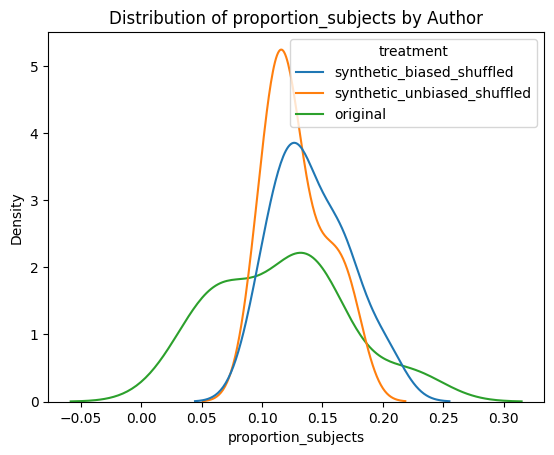

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "proportion_subjects"
author = "dem10"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} by Author')

Text(0.5, 1.0, 'Distribution of proportion_subjects by Author')

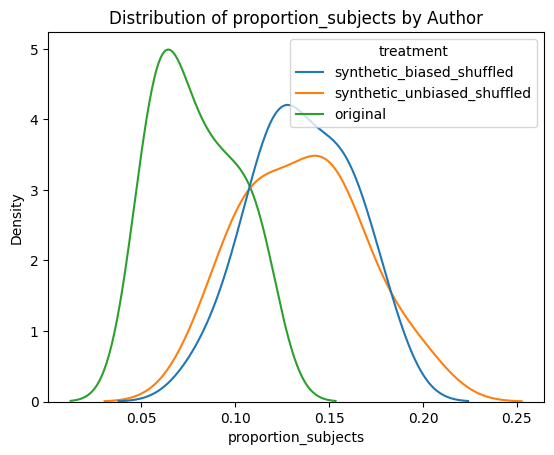

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "proportion_subjects"
author = "dem3"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} by Author')

Text(0.5, 1.0, 'Distribution of coordinate_phrases_ratio for Author dem3')

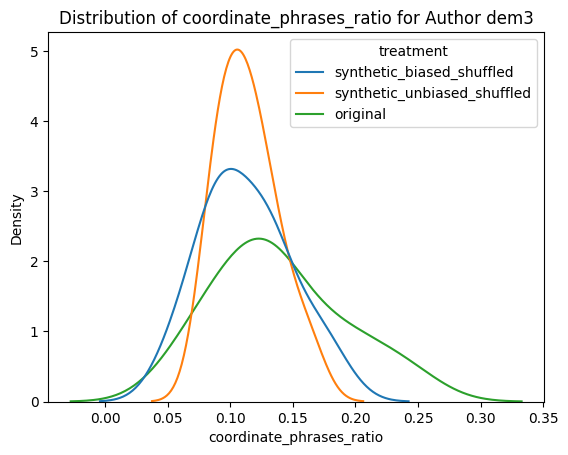

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "coordinate_phrases_ratio"
author = "dem3"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} for Author {author}')

Text(0.5, 1.0, 'Distribution of coordinate_phrases_ratio for Author dem11')

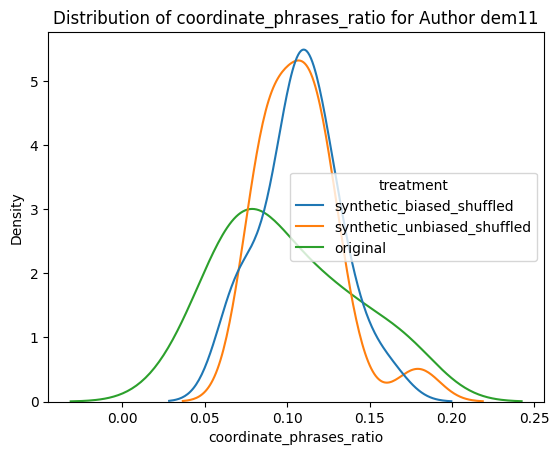

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "coordinate_phrases_ratio"
author = "dem11"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} for Author {author}')

Text(0.5, 1.0, 'Distribution of past_tense_verbs for Author dem11')

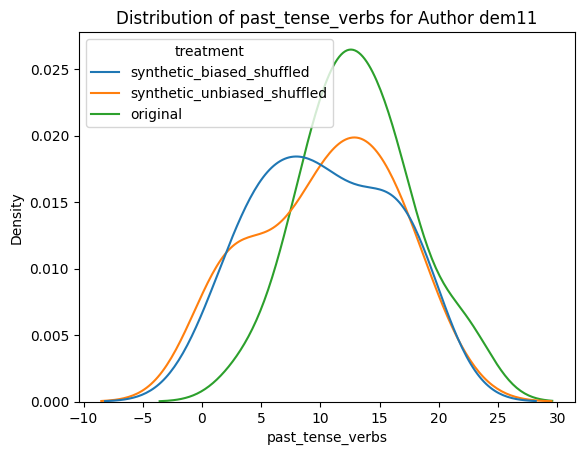

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "past_tense_verbs"
author = "dem11"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} for Author {author}')

Text(0.5, 1.0, 'Distribution of avg_word_length by Author')

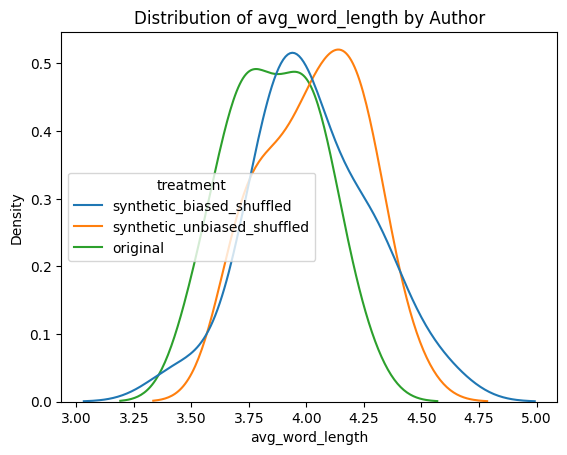

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "avg_word_length"
author = "dem3"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} by Author')

Text(0.5, 1.0, 'Distribution of avg_word_length for Author dem11')

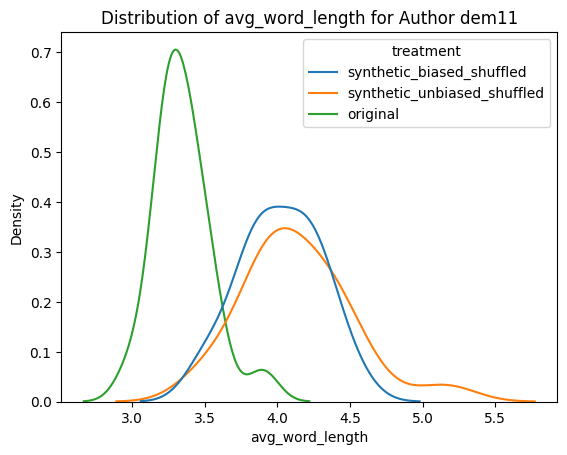

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "avg_word_length"
author = "dem11"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} for Author {author}')

Text(0.5, 1.0, 'Distribution of SUBTL_score_mean for Author dem11')

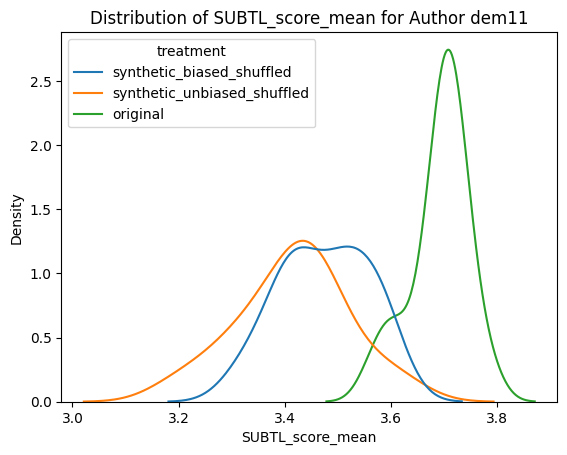

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "SUBTL_score_mean"
author = "dem11"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} for Author {author}')

Text(0.5, 1.0, 'Distribution of SUBTL_score_mean for Author con2')

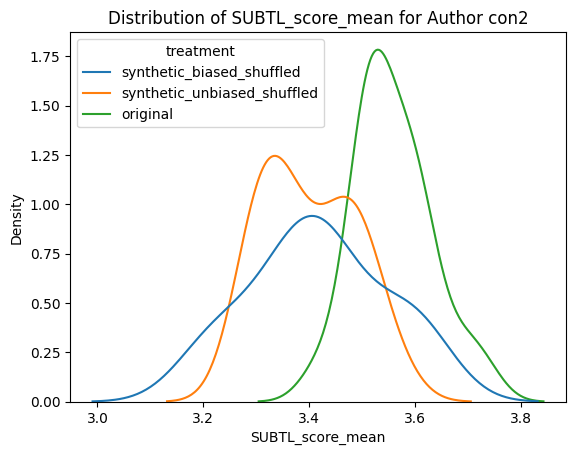

In [ ]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count_snip"]
feature = "SUBTL_score_mean"
author = "con2"
sns.kdeplot(data=df_total.loc[df_total['ID'] == author, :], x=feature, hue='treatment')
plt.title(f'Distribution of {feature} for Author {author}')

In [ ]:
import scipy
t = scipy.stats.ttest_ind(orig_data.loc[orig_data['ID'] == "10dem", 'vp_np_ratio'], df_unbiased.loc[df_unbiased['ID'] == "10dem", 'vp_np_ratio'], equal_var=False)

In [ ]:
t[1]

nan

In [ ]:
df_unbiased[['group']+features].groupby('group').mean()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.382635,9.210000,0.196098,0.118441,2.364586,4.128750,0.128996,3.409180
dem,0.402870,11.080808,0.246876,0.115659,2.508525,4.091869,0.133714,3.438173


In [ ]:
df_biased[['group']+features].groupby('group').mean()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.378631,9.710000,0.208445,0.12524,2.158112,4.079100,0.131795,3.442827
dem,0.414500,10.717172,0.248726,0.11908,2.403361,3.997374,0.138323,3.479061


In [ ]:
df_biased[['group']+features].groupby('group').std()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
group,,,,,,,,
con,0.096991,6.446822,0.144627,0.031308,0.795225,0.278111,0.029801,0.089316
dem,0.107105,6.122958,0.151065,0.024591,0.674935,0.262811,0.034711,0.086352


In [ ]:
orig_data[['ID']+features].groupby('ID').std()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.069420,3.034451,0.084065,0.030834,1.025494,0.156288,0.004129,0.047335
con2,0.090198,2.680829,0.055889,0.032481,3.621414,0.222602,0.017260,0.071412
con4,0.080946,5.775402,0.118810,0.025731,1.420155,0.277815,0.036318,0.095307
con5,0.088957,4.522957,0.135242,0.038284,0.927473,0.396416,0.027545,0.092867
con6,0.220156,7.291668,0.396521,0.028347,0.612638,0.286236,0.013920,0.082097
dem1,0.112817,4.757353,0.129759,0.037952,0.611460,0.173787,0.042188,0.044631
dem10,0.091495,5.005260,0.142097,0.055358,0.677010,0.216501,0.053182,0.062829
dem11,0.074351,4.595192,0.120948,0.040433,1.529953,0.194331,0.029762,0.053299
dem3,0.103853,7.464536,0.225450,0.051870,0.824020,0.200314,0.021894,0.060381


In [ ]:
df_unbiased[['ID']+features].groupby('ID').std()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.084255,5.077297,0.106959,0.026006,0.651441,0.238847,0.017162,0.078283
con2,0.112666,6.687577,0.147803,0.037865,0.951325,0.293242,0.026247,0.100546
con4,0.088485,5.300199,0.124945,0.026710,0.843309,0.282207,0.023743,0.096902
con5,0.089185,6.473427,0.141159,0.031995,0.777147,0.359482,0.024924,0.109220
con6,0.092560,5.977810,0.133552,0.019533,0.548259,0.214481,0.024933,0.068768
dem1,0.097294,6.931811,0.166167,0.031316,1.073022,0.259520,0.019002,0.065347
dem10,0.113142,7.278483,0.166518,0.030838,0.755511,0.251443,0.023545,0.076153
dem11,0.119952,6.083628,0.140058,0.029614,1.035405,0.217014,0.028164,0.088174
dem3,0.110342,5.911630,0.136719,0.020460,0.539209,0.286409,0.028213,0.074169


In [ ]:
df_biased[['ID']+features].groupby('ID').mean()

,determiner_noun_phrase_ratio,past_tense_verbs,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects,SUBTL_score_mean
ID,,,,,,,,
con1,0.320794,8.950000,0.180863,0.111467,1.925391,3.926250,0.134123,3.504532
con2,0.373195,10.400000,0.220342,0.129302,2.248250,4.113000,0.135966,3.422425
con4,0.427864,10.150000,0.222315,0.125233,2.229074,4.075000,0.132944,3.413851
con5,0.360601,10.700000,0.234421,0.137044,2.092012,4.143750,0.135605,3.430477
con6,0.410700,8.350000,0.184285,0.123155,2.295835,4.137500,0.120338,3.442853
dem1,0.392089,10.450000,0.239391,0.115509,2.502830,4.059750,0.133462,3.493740
dem10,0.437735,10.578947,0.250482,0.130097,2.121849,3.889211,0.136025,3.501350
dem11,0.409715,10.750000,0.254255,0.112669,2.602683,4.000250,0.145575,3.471653
dem3,0.405216,11.650000,0.263707,0.114949,2.520417,4.064500,0.142280,3.456869
